## Student contact

Claudia Maiolino

Id: 0001145685

Email adress: claudia.maiolino@studio.unibo.it

# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

import matplotlib.pyplot as plt

import gdown

The next cells contain instructions for downloading data.
**Please, make your own copy.**

In [ ]:
#data
!gdown 1w72-6_9M3KYDeJx8gSxwcbQLHhbpXwjG
!gdown 1tokin0wIXP_JtW9OkVQd3E7lW0KDCk7E
!gdown 1xYtA1g7INgLxwEz-HuAZ71s9UmPLgzUU
#dates
!gdown 15NPNubFv0SUIBsqN_ILUzfa44USTdML7
!gdown 1Kn81OTomZ4PP7qoNpbXdS1-nvmFC2QdM
!gdown 1TXeBE3m9qzxbSQ--4aD81x39s7gfckeT

Downloading...
From: https://drive.google.com/uc?id=1w72-6_9M3KYDeJx8gSxwcbQLHhbpXwjG
To: /content/x_val_night.npy
100% 71.4M/71.4M [00:00<00:00, 119MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1tokin0wIXP_JtW9OkVQd3E7lW0KDCk7E
From (redirected): https://drive.google.com/uc?id=1tokin0wIXP_JtW9OkVQd3E7lW0KDCk7E&confirm=t&uuid=b96af98f-d7f6-4f8d-b60f-42c3c7d5099e
To: /content/x_train_night.npy
100% 382M/382M [00:01<00:00, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xYtA1g7INgLxwEz-HuAZ71s9UmPLgzUU
To: /content/x_test_night.npy
100% 58.7M/58.7M [00:00<00:00, 241MB/s]
Downloading...
From: https://drive.google.com/uc?id=15NPNubFv0SUIBsqN_ILUzfa44USTdML7
To: /content/dates_val_night.npy
100% 4.49k/4.49k [00:00<00:00, 13.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Kn81OTomZ4PP7qoNpbXdS1-nvmFC2QdM
To: /content/dates_train_night.npy
100% 23.5k/23.5k [00:00<00:00, 65.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TXeBE3m9qzxb

In [ ]:
#land-sea mask
!gdown 1DBB4d7GT5MLVjvTMySWS5UfpBhZxkzMn

Downloading...
From: https://drive.google.com/uc?id=1DBB4d7GT5MLVjvTMySWS5UfpBhZxkzMn
To: /content/land_sea_mask.npy
100% 16.5k/16.5k [00:00<00:00, 38.7MB/s]


In [ ]:
#a statistical baseline
!gdown 1tCRBtkYeHkyLrENWM-9mNVX1bXGjp9g3

Downloading...
From: https://drive.google.com/uc?id=1tCRBtkYeHkyLrENWM-9mNVX1bXGjp9g3
To: /content/stat_baseline.npy
100% 48.0M/48.0M [00:00<00:00, 213MB/s]


Le us inspect and visualize data.

In [ ]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

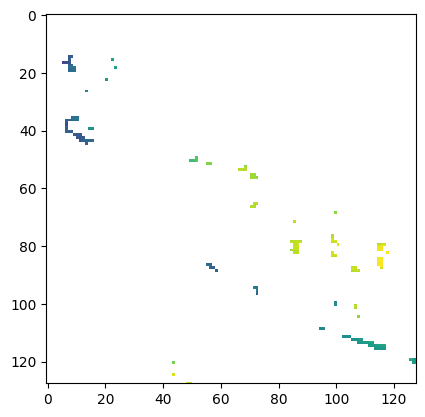

In [ ]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds
plt.show()

In [ ]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


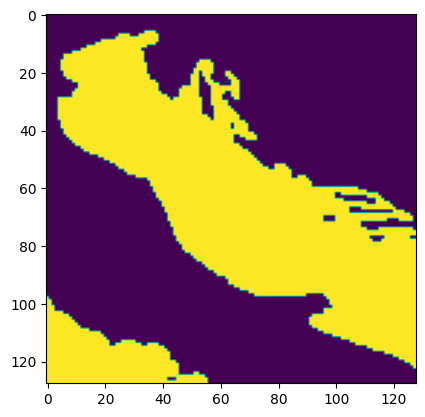

In [ ]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [ ]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")
print(f"mean baseline temperature: {np.nanmean(baseline)}")
print(f"std baseline temperature: {np.nanstd(baseline)}\n")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889
mean baseline temperature: 7.435923494950842
std baseline temperature: 9.487184760860446



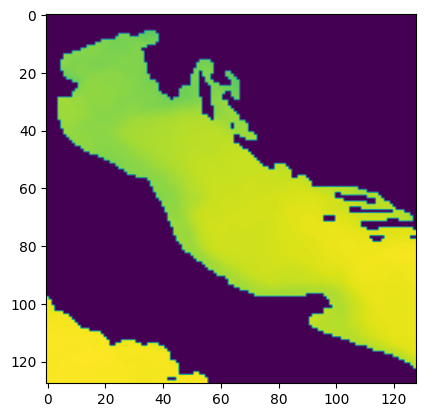

In [ ]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [ ]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [ ]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [ ]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [ ]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [ ]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 15.294999973882312
image 0; 0.0, 15.294999973882312
image 1; 0.0, 15.294999973882312
image 2; 0.0, 15.2548199690574


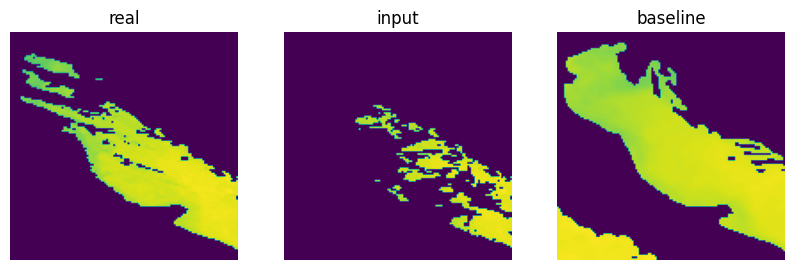

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


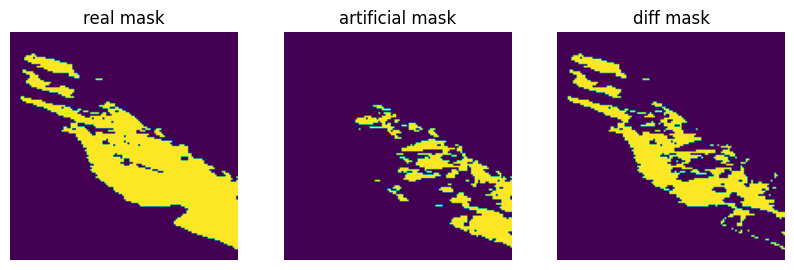

In [ ]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6316914083496298
RMSE std : 0.18529834441259638


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


# Introduction


For this project I focused on developing two kinds of neural networks:
- **U-NET**, since we have discussed during the lessons how good are its perfomances in problem of image reconstruction, as the case of this issue.
- **MAE** (Masked Autoencoders) following the idea found in this article: *E. Goh, A. Yepremyan, I. Ward, J. Wang and B. Wilson, "Reconstruction of Sea Surface Temperature under Clouds using Masked Autoencoders," IGARSS 2023 - 2023 IEEE International Geoscience and Remote Sensing Symposium, Pasadena, CA, USA, 2023, pp. 1076-1079, doi: 10.1109/IGARSS52108.2023.10282485.*

From the very first moment I noticed how MAE was very difficult to training properly and how much risources required, due to his high complexity. For this reason, considering the limited amount of time and computational power, and for the fact that, at first look, seems that U-NET works even better than MAE, I choose to focus on training and fine-tuning the hyperparameters concern the simpler U-NET.


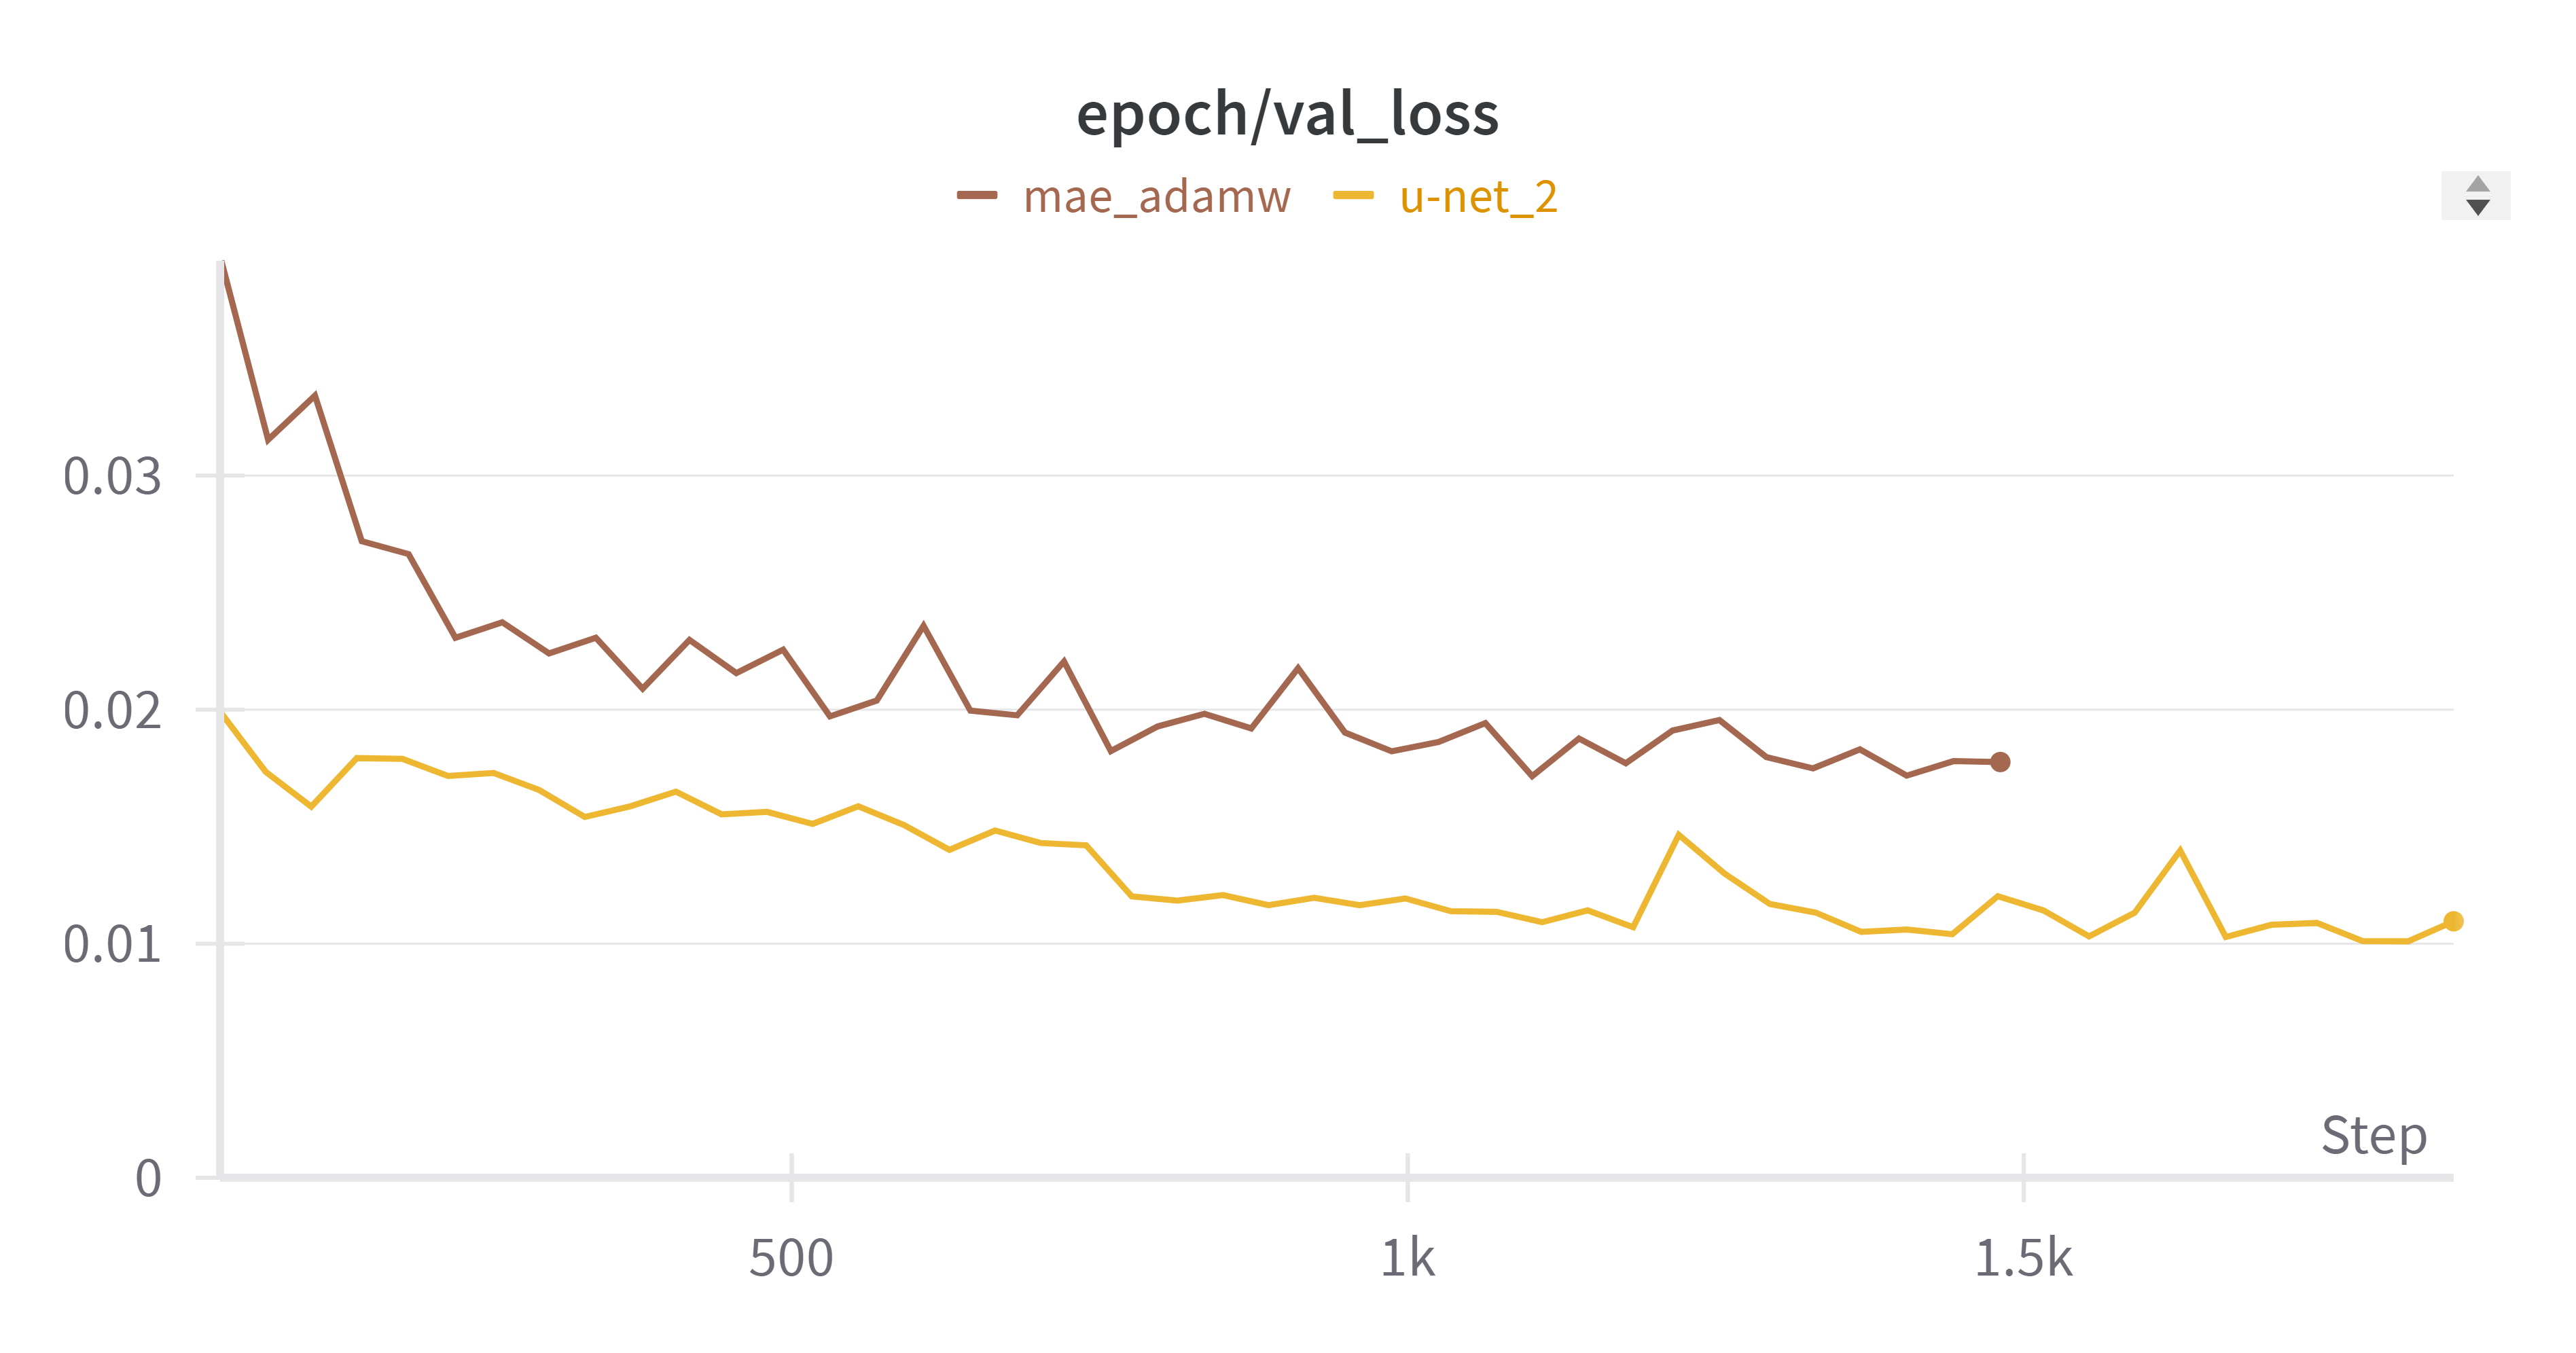

In this image, done using WANDB, we can see the difference of the performances, at the first training. I suppose that MAE requires much more works in terms of fine-tuning and, since the problem and the dataset of the assignment are not so complex, probably U-NET is preferable.


# Network


For this project I implement a U-NET with residual blocks. The main components are:
- The encoder part implemented in the **residual_conv_block**
- The decoder part implemented in the **residual_deconv_block**
- The central part implemented with the classical **bottleneck** structure

I decided to adding *bacth_normalization* layers and implementing the *residual connections* and the kernal_initialzer with *he_normal* in order to stabilize the process of training and avoid the vanishing gradient problem.

The network riceves as **input** the $batch_x$ made by the generator function with shape $(batch size, 128, 128, 4)$ and returns as **output** an object with dimension $(batch size, 128, 128, 1)$ to compare with $batch_y[..,0]$ on the diff_mask $batch_y[..,2]$.

In [ ]:
def residual_conv_block(inputs, num_filters, kernel_initializer='he_normal'):
    #Encoder block
    shortcut = layers.Conv2D(num_filters, (1, 1), padding='same', kernel_initializer=kernel_initializer)(inputs)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def residual_deconv_block(inputs, skip_features, num_filters, kernel_initializer='he_normal'):
    #Decoder block
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(inputs)
    x = layers.concatenate([x, skip_features])
    shortcut = layers.Conv2D(num_filters, (1, 1), padding='same', kernel_initializer=kernel_initializer)(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    return x

def improved_unet(input_shape=(128, 128, 4), output_channels=1, num_filters=64, num_blocks=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    skips = []
    x = inputs
    for i in range(num_blocks):
        x, p = residual_conv_block(x, num_filters)
        skips.append(x)
        x = p
        num_filters *= 2

    # Bottleneck
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    for i in reversed(range(num_blocks)):
        num_filters //= 2
        x = residual_deconv_block(x, skips[i], num_filters)

    outputs = layers.Conv2D(output_channels, (1, 1), activation='linear')(x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


# Training

## Experiments design

For this project I worked mainly using the GPU of Google Colab and Kaggle when the first was not avaible (since the limitation of the free plan). I also used [Weights And Biases](https://wandb.ai/site) to save the models and to keep track of the process of training.

In [ ]:
!pip install wandb

## Custom loss and metric

Due to the specification of this probelm and in particulr the porpuse of the final evaluation, I thought that it was necessary to write custom loss and metric.
- **custom loss**: a MSE of the difference between the ground trouth given by $batch_y[...,0]$ and the output of the network, applied only on the difference of the masks region $batch_y[...,2]$.
- **custom metric**: the same as above but applying RMSE.



In [ ]:
import tensorflow.keras.backend as K

def masked_mse_loss(y_true, y_pred):
    # y_true shape: (batch_size, height, width, 3)
    # y_pred shape: (batch_size, height, width, 1)

    real_image = y_true[..., 0]
    diff_mask = y_true[..., 2]

    y_pred = tf.squeeze(y_pred, axis=-1)

    real_image = tf.cast(real_image, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)
    diff_mask = tf.cast(diff_mask, dtype=tf.float64)
    squared_error = tf.square(real_image - y_pred)

    masked_error = squared_error * diff_mask

    sum_errors = tf.reduce_sum(masked_error)
    sum_mask = tf.reduce_sum(diff_mask)

    sum_mask = tf.maximum(sum_mask, 1e-8)

    return sum_errors / sum_mask

In [ ]:
def masked_rmse_metric(y_true, y_pred):
    # y_true shape: (batch_size, height, width, 3)
    # y_pred shape: (batch_size, height, width, 1)

    real_image = y_true[..., 0]
    diff_mask = y_true[..., 2]

    y_pred = tf.squeeze(y_pred, axis=-1)

    real_image = tf.cast(real_image, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)
    diff_mask = tf.cast(diff_mask, dtype=tf.float64)
    squared_error = tf.square(real_image - y_pred)

    masked_error = squared_error * diff_mask

    sum_errors = tf.reduce_sum(masked_error)
    sum_mask = tf.reduce_sum(diff_mask)

    sum_mask = tf.maximum(sum_mask, 1e-8)

    return tf.sqrt(sum_errors / sum_mask)

## Hyperparameters

The best configuration of hyperparameters I found is:

For the *network*:
- **num_filters**: -> 64 (number of the filters at the first convolutional layer)
- **num_blocks**: -> 4 (number of encoder and decoder blocks)

For the *training*
- **batch_size**: -> 32
- **leraning_rate**: -> 1e-3 (initial leraning rate, varies if using some scheduler)
- **weight_decay**: -> 1e-6 (useful when using AdamW optimizer)
- **epochs**: -> 50 (number of epochs used for train the model)
- **optimizer**:-> adamw (refers to the choiche of AdamW optimizer)
- **lr_scheduler**:-> plateu (refers to ReduceLrOnPlateau callback)
- **data_augmentation**:-> False (True if a sort of Data Augmentation is performed)
- **steps_per_epoch**:-> 180 (the computation is made through the division of the train_dataset dimension by the batch_size)
- **validation_step**:-> 34 (the computation is made through the division of the validation_dataset dimension by the batch_size)

In [ ]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

USE_WANDB = True  # True if we want to log to WANDB
DOWNLOAD_MODEL = False # True if we want to donwload the trained model
MODEL_TO_DOWNLOAD = 'jeanclaude8-universit-di-bologna/SST_assignment/u-net_2.keras:v3' # Name of the trained model from wandb
CONTINUE_TRAINING = True # True if we want to train the model
MODEL_NAME = 'u-net_2.keras'

cfg = {
    "num_filters": 64,
    "num_blocks": 4,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 1e-6,
    "epochs": 50,
    "optimizer": "adamw",
    "lr_scheduler" : "plateau",
    "data_augmentation": False,
    "steps_per_epoch" : 180,
    "validation_step" : 34
}


if USE_WANDB:
    run = wandb.init(
        # Set the WANDB project where this run will be logged
        project='SST_assignment',
        # Track hyperparameters and run metadata with the config object
        config=cfg
    )

wandb: Currently logged in as: jeanclaude8 (jeanclaude8-universit-di-bologna). Use `wandb login --relogin` to force relogin


## Model definition

The model is composed by **31,914,625** trainable parameters and **11,776** not-trainable parameters. I'm aware of the huge number of parameters, and for this reason I also tried to test a smaller network (with only 3 number of blocks, and 7,917,697 trainable parameters). As we can see in the graph, the performance is quite similar and good enough, but if we focus on the average of the RMSE on the test generator is a little bit worse than the bigger network. Since there are no restrictions on the number of parameters, I chose the bigger one.
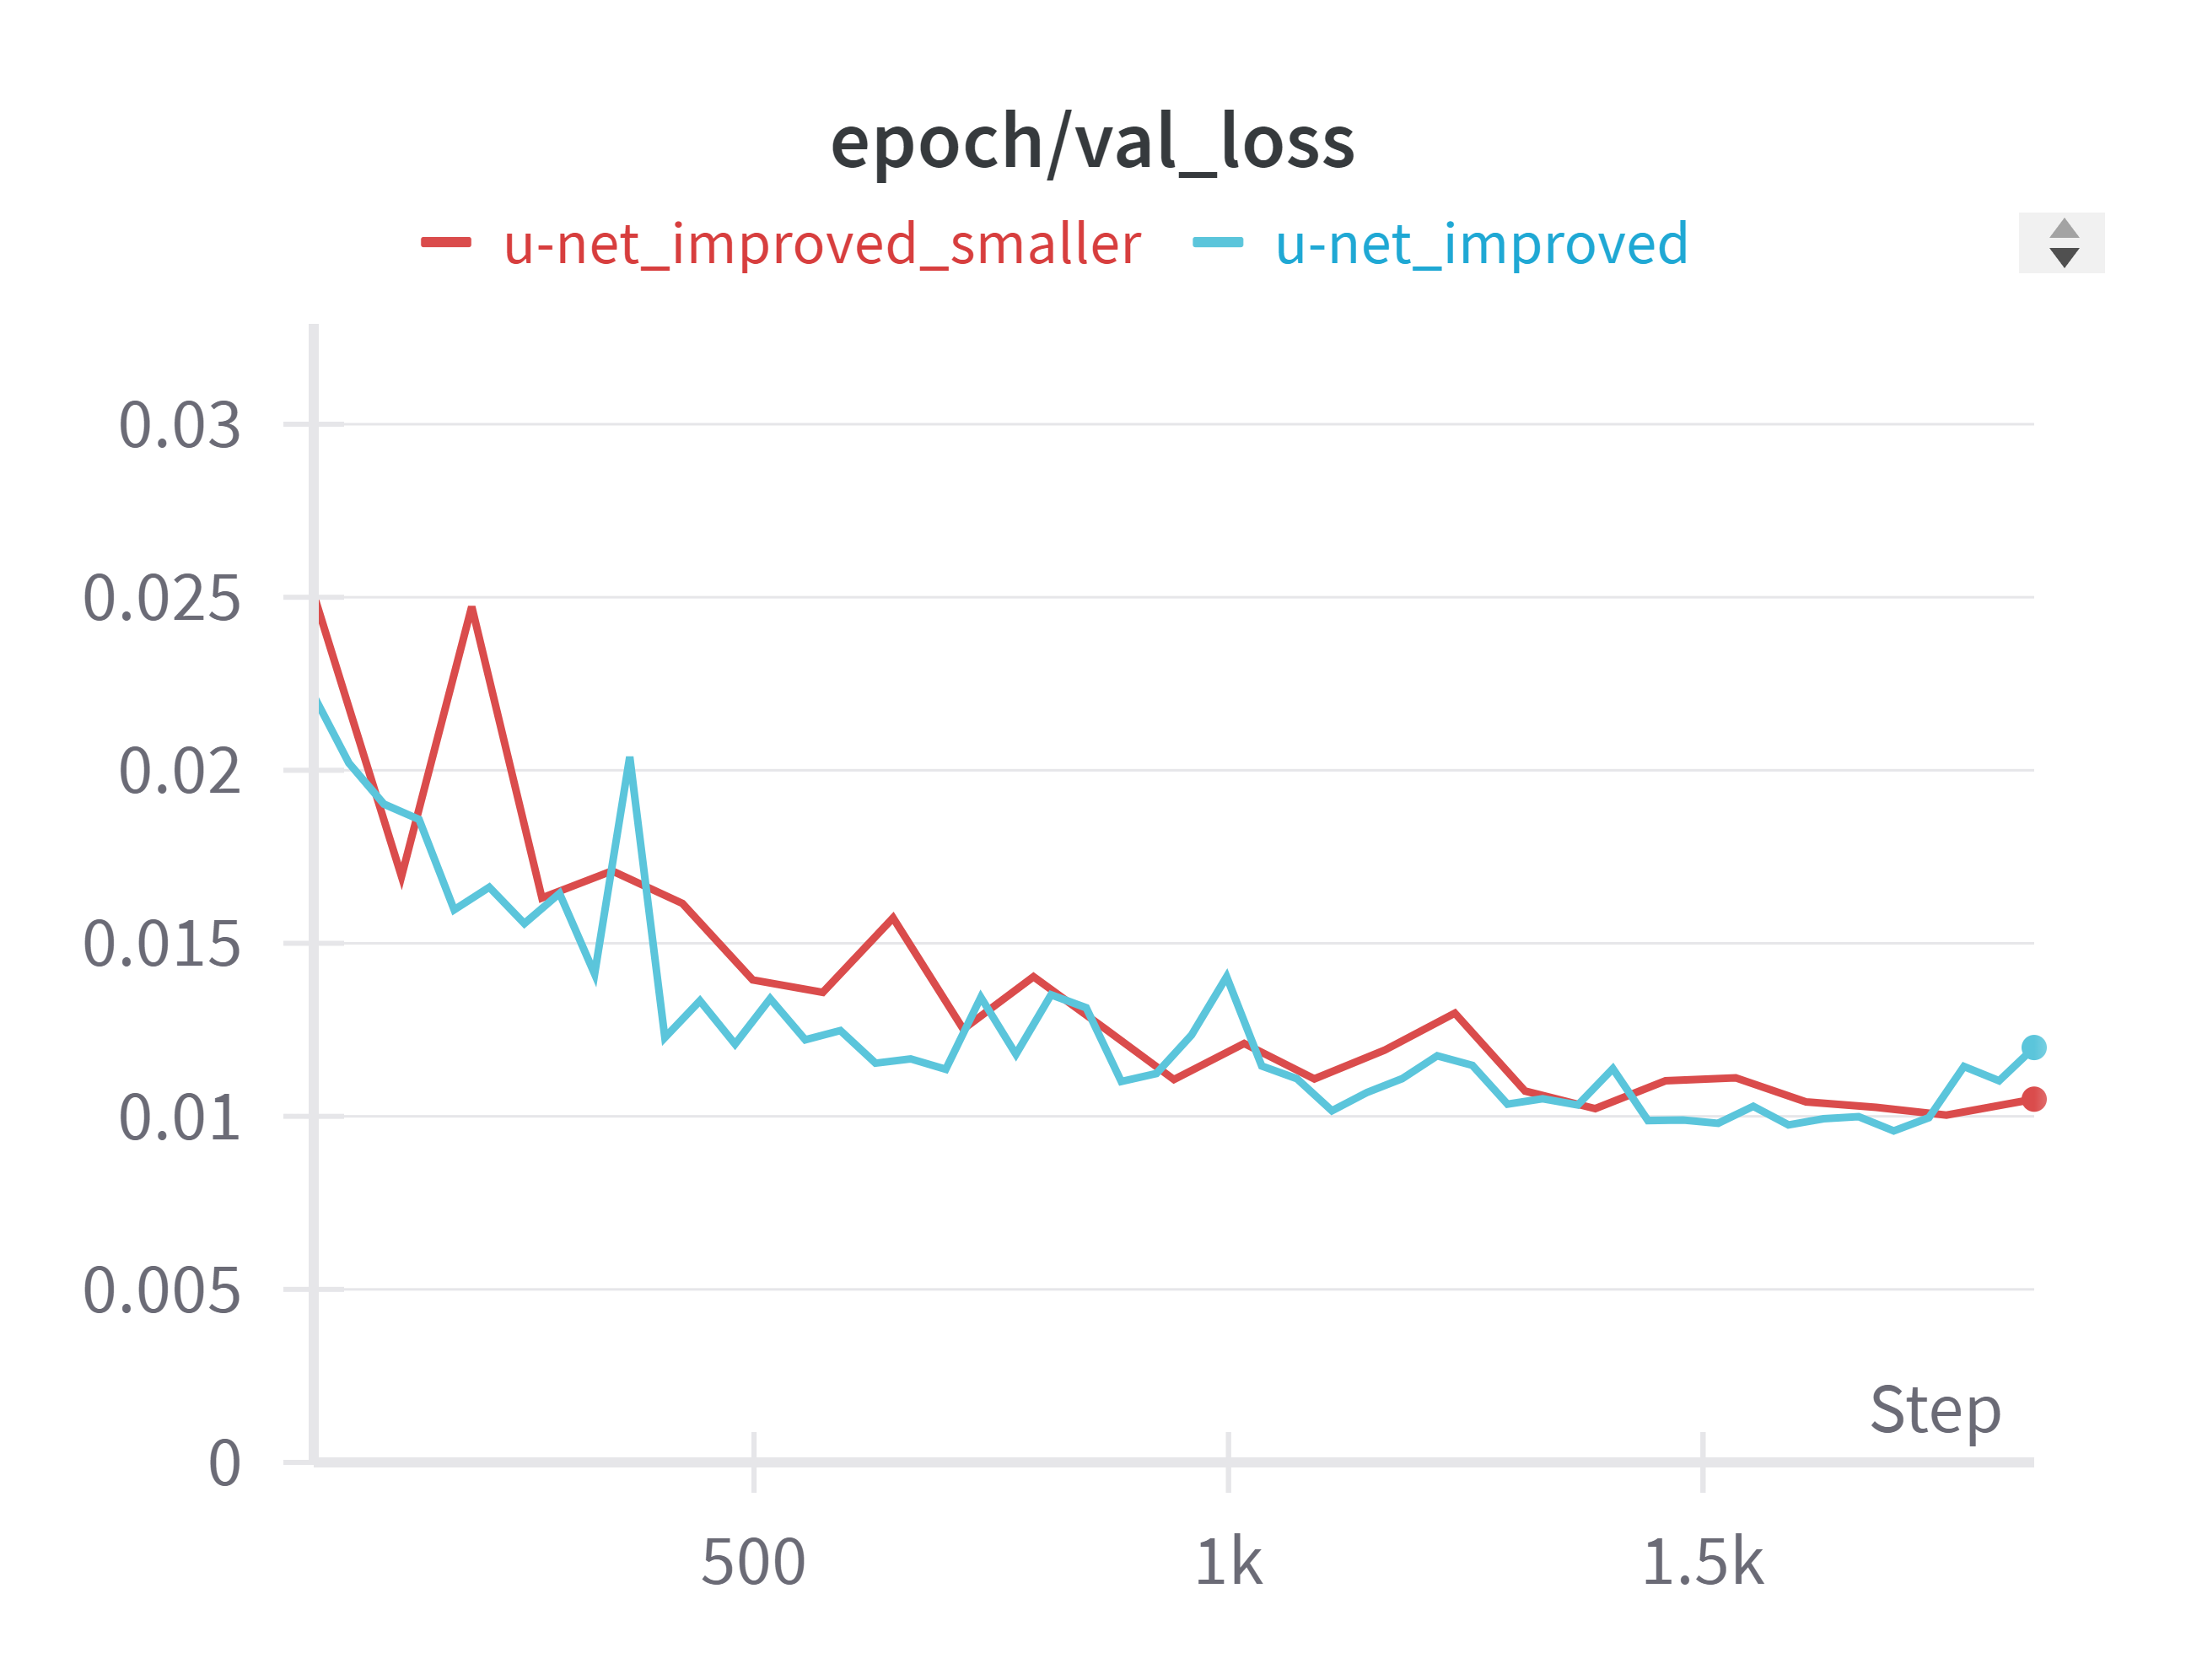

In [ ]:
if CONTINUE_TRAINING:
  model = improved_unet(num_filters=cfg["num_filters"], num_blocks=cfg["num_blocks"])
  model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 64)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │          8,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 31,926,401 (121.79 MB)

 Trainable params: 31,914,625 (121.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
import os
if DOWNLOAD_MODEL:
  if USE_WANDB:
    artifact = run.use_artifact(MODEL_TO_DOWNLOAD, type='model')
    artifact_dir = artifact.download()
    load_model = tf.keras.models.load_model(os.path.join(artifact_dir, MODEL_NAME), compile=False)
  else:
   load_model = tf.keras.models.load_model(MODEL_NAME, compile=False)

  load_model.summary()

## Callbacks

In addition to the WANDB callbacks for the checkpoints I used also:
- An Early Stopping that monitor the val-loss and stop the training after 10 epochs without improvment
- I tested different learning rate scheduler:
  - Plateu: that halve the learning rate after 5 epochs without improving
  - Constant: that let the learning rate constant
  - Decay: that perform a linear decay of the leraning rate

In [ ]:
##Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)


In [ ]:
##Learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

lr_scheduler_plateau = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=5,
                                 min_lr=1e-7,
                                 verbose=1)

lr_scheduler_decay = LearningRateScheduler(lambda epoch: cfg["learning_rate"] * 0.95 ** epoch)

lr_scheduler_constant = LearningRateScheduler(lambda epoch: cfg["learning_rate"])


## Data augmentation

In some experiments I perform a data augmentation consisting on random horizontal and vertical flipping and rotation but actually the performance not change so much

In [ ]:
##Data Augmentation
from scipy.ndimage import rotate

def apply_data_augmentation(batch_x, batch_y):
    augmented_batch_x = np.copy(batch_x)
    augmented_batch_y = np.copy(batch_y)
    batch_size = batch_x.shape[0]

    for i in range(batch_size):
        if np.random.rand() > 0.5:
            augmented_batch_x[i] = np.flipud(augmented_batch_x[i])
            augmented_batch_y[i] = np.flipud(augmented_batch_y[i])

        if np.random.rand() > 0.5:
            augmented_batch_x[i] = np.fliplr(augmented_batch_x[i])
            augmented_batch_y[i] = np.fliplr(augmented_batch_y[i])

        if np.random.rand() > 0.5:
            angle = np.random.randint(-15, 15)
            augmented_batch_x[i] = rotate(augmented_batch_x[i], angle, reshape=False)
            augmented_batch_y[i] = rotate(augmented_batch_y[i], angle, reshape=False)


    return augmented_batch_x, augmented_batch_y


def augmented_generator(generator, augmentation_probability=1.0):
    for batch_x, batch_y in generator:
        if np.random.rand() < augmentation_probability:
            batch_x, batch_y = apply_data_augmentation(batch_x, batch_y)
        yield batch_x, batch_y

def get_augmentation_probability(epoch, max_epochs, final_probability=0.5):
    return min(epoch / (2 * max_epochs), 1.0) * final_probability

## Training loop

In [ ]:
if CONTINUE_TRAINING:
    # Choose the optimizer based on the configuration
    if cfg["optimizer"] == "adam":
        optimizer = Adam(learning_rate=cfg["learning_rate"], clipnorm = 1.0)
    elif cfg["optimizer"] == "adamw":
        optimizer = AdamW(learning_rate=cfg["learning_rate"], weight_decay=cfg["weight_decay"], clipnorm = 1.0)
    else:
        raise ValueError(f'Unknown optimizer: {cfg["optimizer"]}')

    # Choose the learning rate scheduler based on the configuration
    if cfg["lr_scheduler"] == "constant":
        lr_scheduler = lr_scheduler_constant
    elif cfg["lr_scheduler"] == "decay":
        lr_scheduler = lr_scheduler_decay
    elif cfg["lr_scheduler"] == "plateau":
        lr_scheduler = lr_scheduler_plateau
    else:
        raise ValueError(f'Unknown lr_scheduler: {cfg["lr_scheduler"]}')

    # Set the loss function and the metric
    loss = masked_mse_loss
    metric = masked_rmse_metric

    # Set the steps per epoch parameters
    steps_per_epoch = cfg['steps_per_epoch']
    validation_steps = cfg['validation_step']

    # Compile the model with the chosen optimizer,loss function and metric
    model.compile(optimizer=optimizer, loss=loss, metrics = [metric])

    DATA_AUGMENTATION = cfg['data_augmentation']

    # Training the model with data augmentation
    if DATA_AUGMENTATION:
      max_epochs = cfg['epochs']
      initial_epoch = 1

      for epoch in range(initial_epoch, max_epochs):
          aug_prob = get_augmentation_probability(epoch, max_epochs)

          train_gen = augmented_generator(train_gen,
                                          augmentation_probability=aug_prob)
          if USE_WANDB:
              history = load_model.fit(
                  train_gen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=1,
                  validation_data=val_gen,
                  validation_steps=validation_steps,
                  callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint('u-net_2_checkpoint.keras', monitor="val_loss", save_best_only=True, save_weights_only=False),
                      lr_scheduler,
                      early_stopping
                  ]
                  )
          else:
              history = load_model.fit(
                  train_gen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=1,
                  validation_data=val_gen,
                  validation_steps=validation_steps,
                  callbacks=[
                      lr_scheduler,
                      early_stopping
                  ]
                  )

          print(f"Epoch {epoch+1}/{max_epochs}, Augmentation Probability: {aug_prob:.2f}, Loss: {history.history['loss'][-1]:.4f}, Val Loss: {history.history['val_loss'][-1]:.4f}")

    # Training the model without data augmentation
    else:
        if USE_WANDB:
            history = model.fit(train_gen,
                                epochs=cfg['epochs'],
                                validation_data=val_gen,
                                steps_per_epoch = steps_per_epoch,
                                validation_steps = validation_steps,
                                callbacks=[
                WandbMetricsLogger(log_freq=5),
                WandbModelCheckpoint('model_checkpoint.keras', monitor="val_loss", save_best_only=True, save_weights_only=False),
                lr_scheduler,
                early_stopping
            ])
        else:
            history = model.fit(train_gen,
                                epochs=cfg["epochs"],
                                validation_data=val_gen,
                                steps_per_epoch = steps_per_epoch,
                                validation_steps = validation_steps,
                                callbacks=[
                lr_scheduler,
                early_stopping
            ])


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 224s 771ms/step - loss: 21.1864 - masked_rmse_metric: 1.8115 - val_loss: 0.0222 - val_masked_rmse_metric: 0.1486 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 110s 611ms/step - loss: 0.0239 - masked_rmse_metric: 0.1541 - val_loss: 0.0202 - val_masked_rmse_metric: 0.1419 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 121s 671ms/step - loss: 0.0223 - masked_rmse_metric: 0.1489 - val_loss: 0.0190 - val_masked_rmse_metric: 0.1377 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 604ms/step - loss: 0.0212 - masked_rmse_metric: 0.1452 - val_loss: 0.0186 - val_masked_rmse_metric: 0.1361 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 107s 595ms/step - loss: 0.0207 - masked_rmse_metric: 0.1436 - val_loss: 0.0160 - val_masked_rmse_metric: 0.1261 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 104s 576ms/step - loss: 0.0205 - masked_rmse_metric: 0.1426 - val_loss: 0.0166 

In [ ]:
#Saving the model
if USE_WANDB:
      model.save(MODEL_NAME, overwrite=False)
      artifact = wandb.Artifact(MODEL_NAME, type='model')
      artifact.add_file(MODEL_NAME)
      run.log_artifact(artifact)
else:
  model.save(MODEL_NAME, overwrite=False)

# Training plot

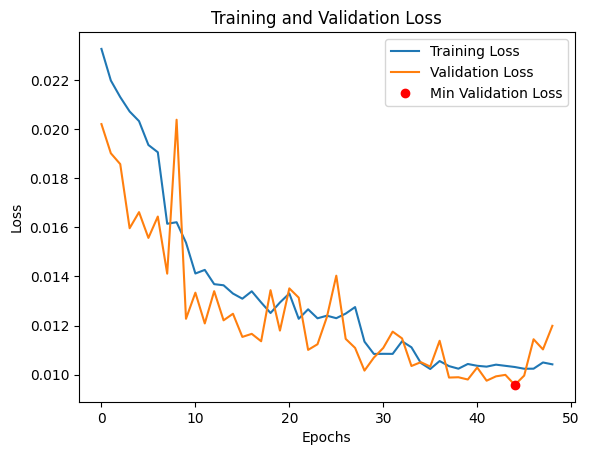

In [ ]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
min_val_loss_value = np.min(val_loss)
min_val_loss_epoch = np.argmin(val_loss)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot(min_val_loss_epoch, min_val_loss_value, 'ro', label="Min Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final evaluation

The final evaluation is performed following what is written on the assignment. The only change of the code I have to make is refered to

```
predictions = tf.squeeze(predictions, axis=-1)  #ONLY MODIFICATION I PERFROM TO RESHAPE THE OUTPUT OF THE NETWORK
```

where I reshape the output of my network in order to let it comparable.

As we can see the result is quite better than what the baseline performs:
- **RMSE : 0.46754417**
- **RMSE std : 0.1457991**

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []
if DOWNLOAD_MODEL:
  model = load_model
# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model.predict(batch_x, verbose=0)
    #predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions = tf.squeeze(predictions, axis=-1)  #ONLY MODIFICATION I PERFROM TO RESHAPE THE OUTPUT OF THE NETWORK
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.46754417
RMSE std : 0.1457991
